# Dog Breed Classification
This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

from sagemaker import get_execution_role
from sagemaker.session import Session

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from  sagemaker.pytorch import PyTorch

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip

In [5]:
session = sagemaker.Session()
role = get_execution_role()

In [6]:
bucket = session.default_bucket()
bucket

'sagemaker-us-east-1-001237971406'

In [7]:
data_chanel = 's3://sagemaker-us-east-1-001237971406/Dataset'

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [9]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "batch_size": CategoricalParameter([ 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [10]:
from  sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "dog-breed-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.p3.2xlarge",
    py_version = "py36",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({"training": data_chanel}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [14]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-07-10 00:42:38 Starting - Preparing the instances for training
2022-07-10 00:42:38 Downloading - Downloading input data
2022-07-10 00:42:38 Training - Training image download completed. Training in progress.
2022-07-10 00:42:38 Uploading - Uploading generated training model
2022-07-10 00:42:38 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'eps': '4.76091297581532e-09',
 'lr': '0.0001667849539023839',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-hpo-2022-07-09-23-50-01-024"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-001237971406/dog-breed-hpo-2022-07-09-23-50-01-024/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [15]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "100","eval.save_interval": "10"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs)

In [16]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr']}

In [17]:
estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    framework_version="1.6",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, 
    debugger_hook_config=debugger_config,
    rules=rules
)

estimator.fit({"training": data_chanel}, wait=True)

2022-07-10 00:44:00 Starting - Starting the training job...LossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2022-07-10 00:44:59 Starting - Preparing the instances for training......
2022-07-10 00:45:59 Downloading - Downloading input data............
2022-07-10 00:48:00 Training - Downloading the training image...
2022-07-10 00:48:26 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-10 00:48:28,958 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-10 00:48:28,984 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-10 00:48:28,991 sagemaker_pytorch_container.training INFO     Invoking user training script.
2

In [18]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import IPython

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-07-10 00:55:24.812 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:588 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-07-10 00:55:24.826 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:588 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-001237971406/pytorch-training-2022-07-10-00-43-59-851/debug-output


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

It seems there do exist overfit and overtraining error, I will look through the logs and change the model parameter, then retrain the model to get rid of those errors.

In [19]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-001237971406/pytorch-training-2022-07-10-00-43-59-851/rule-output


In [20]:
! aws s3 ls {rule_output_path} --recursive

2022-07-10 00:54:59     381420 pytorch-training-2022-07-10-00-43-59-851/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-07-10 00:54:58     230574 pytorch-training-2022-07-10-00-43-59-851/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-07-10 00:54:54        191 pytorch-training-2022-07-10-00-43-59-851/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-07-10 00:54:54      16038 pytorch-training-2022-07-10-00-43-59-851/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-07-10 00:54:54        126 pytorch-training-2022-07-10-00-43-59-851/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-07-10 00:54:54        129 pytorch-training-2022-07-10-00-43-59-851/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-07-10 00:54:54       4549 pytorch-training-2022-07-10-00-43-59-851/rule-output/ProfilerReport/profiler-output/profiler-re

In [21]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-001237971406/pytorch-training-2022-07-10-00-43-59-851/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-001237971406/pytorch-training-2022-07-10-00-43-59-851/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-001237971406/pytorch-training-2022-07-10-00-43-59-851/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-001237971406/pytorch-training-2022-07-10-00-43-59-851/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-001237971406/pytorc

In [22]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [24]:
#IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [109]:
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.c5.large")

------!

In [26]:
endpoint = predictor.endpoint_name
endpoint

'pytorch-training-2022-07-10-00-56-56-495'

In [31]:
import os
os.getcwd()

'/root/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter'

In [89]:
# TODO: Run an prediction on the endpoint
from sagemaker.serializers import IdentitySerializer
from IPython.display import display, Image
import base64

image = "./test/Affenpinscher_00003.jpg" # Expected 1

predictor.serializer = IdentitySerializer("image/png")
with open(image, "rb") as f:
    payload = f.read()
    
#response = predictor.predict(image)

In [118]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

model = "s3://sagemaker-us-east-1-001237971406/pytorch-training-2022-07-10-00-56-56-495/model.tar.gz"
        
pytorch_model = PyTorchModel(model_data = model,
                             role = role,
                             entry_point= "endpoint.py",
                             py_version = "py36",
                             framework_version = "1.6")

predictor = pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.t2.medium")

--------!

In [130]:
response = predictor.predict(payload)
np.argmax(response) + 1

1

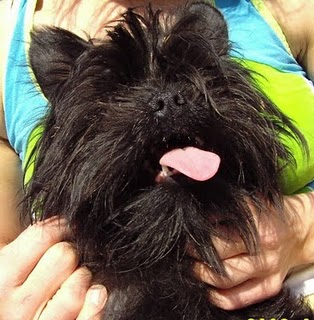

In [131]:
with open(image, "rb") as f:
    payload = f.read()
    display(Image.open(io.BytesIO(payload)))

I choose this image from the test set, which exactly correpsonds to Type 1
S3 Path : "s3://sagemaker-us-east-1-001237971406/Dataset/test/**001**.Affenpinscher/Affenpinscher_00003.jpg"

In [132]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictork.delete_endpoint()